In [1]:
# Author : Arthur Prigent
# Email: aprigent@geomar.de

In [2]:
from load_librairies import *
import xscale.signal.fitting as xsf
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

period_str_1 = 1950
period_end_1 = 1999

period_str_2 = 2050
period_end_2 = 2099

def is_jja(month):
    return (month >= 6) & (month <= 8)
def is_mjj(month):
    return (month >= 5) & (month <= 7)
def is_amj(month):
    return (month >= 4) & (month <= 6)

def relative_std(a, b):
    return (a - b) / a

def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

def month_range_day(start=None, periods=None):
    start_date = pd.Timestamp(start).date()
    month_range = pd.date_range(start=start_date, periods=periods, freq='M')
    month_day = month_range.day.values
    month_day[start_date.day < month_day] = start_date.day
    return pd.to_datetime(month_range.year*10000+month_range.month*100+month_day, format='%Y%m%d')
######################
#      TO CHANGE     # 
######################

path_fig = '/Users/aprigent/Documents/Thesis_GEOMAR/Projects/weakened_sst_variability_CMIP5/figures/new_version/reviews/'
path_data = '/Users/aprigent/Documents/Thesis_GEOMAR/Projects/weakened_sst_variability_CMIP5/scripts/new_version/to_publish/data/'

# Observations winds


In [3]:
nc = xr.open_dataset(
    '/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERA_INTERIM/ERA_interim_uv_1979_2018_1x1.nc')
nc = nc.sel(time=slice(datetime(2000, 1, 1), datetime(2014, 12, 31)))
u10_eraint = nc.u10[:,:,:]
u10_eraint = xr.concat([u10_eraint[:, :, 180:], u10_eraint[:, :, :180]], dim='longitude')
u10_eraint.coords['longitude'] = (u10_eraint.coords['longitude'] + 180) % 360 - 180

u10_eraint = u10_eraint.chunk(chunks=None)
u10_eraint = xsf.detrend(u10_eraint,dim='time',type='linear')

In [4]:
u10_eraint_atl4 = Atools.data_sub(u10_eraint,-40,-20,-3,3).mean(dim='longitude').mean(dim='latitude')
u10a_eraint_atl4,_ = Atools.ano_norm_t(u10_eraint_atl4.load())
std_u10a_eraint_atl4_amj = u10a_eraint_atl4.sel(time=is_amj(
    u10a_eraint_atl4['time.month'])).std(dim='time')

In [4]:
nc = xr.open_dataset(
    '/Users/aprigent/Documents/Thesis_GEOMAR/Data/NCEP-R2/uwnd.10m.mon.mean_NCEPDOE.nc')
nc = nc.sel(time=slice(datetime(2000, 1, 1), datetime(2014, 12, 31)))
u10_ncep = nc.uwnd[:,0,:,:]
u10_ncep = xr.concat([u10_ncep[:, :, 96:], u10_ncep[:, :, :96]], dim='lon')
u10_ncep.coords['lon'] = (u10_ncep.coords['lon'] + 180) % 360 - 180

u10_ncep = u10_ncep.chunk(chunks=None)
u10_ncep = xsf.detrend(u10_ncep,dim='time',type='linear')

In [5]:
u10_ncep_atl4 = Atools.data_sub(u10_ncep,-40,-20,-3,3).mean(dim='lon').mean(dim='lat')
u10a_ncep_atl4,_ = Atools.ano_norm_t(u10_ncep_atl4.load())
std_u10a_ncep_atl4_amj = u10a_ncep_atl4.sel(time=is_amj(
    u10a_ncep_atl4['time.month'])).std(dim='time')

In [6]:
## Load mask ##
nc_mask = xr.open_dataset(
    '/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERA5/ERA_landsea_mask.nc')
lsm = nc_mask.lsm[0,:,:]
lsm = xr.concat([lsm[ :, 720:], lsm[ :, :720]], dim='longitude')
lsm.coords['longitude'] = (lsm.coords['longitude'] + 180) % 360 - 180

## Load data ##
nc = xr.open_dataset(
    '/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERA5/era5_uwnd10m_1982_2019.nc')

## Take the period 1982/01 - 2017/12 ##
nc = nc.sel(time=slice(datetime(2000, 1, 1), datetime(2014, 12, 31)))
u10_era5 = nc.u10
u10_era5 = xr.concat([u10_era5[:, :, 720:], u10_era5[:, :, :720]], dim='longitude')
u10_era5.coords['longitude'] = (u10_era5.coords['longitude'] + 180) % 360 - 180

## Apply mask ##
u10_era5 = u10_era5.where(lsm[:,:]==0)

## Detrend data ##
u10_era5_nondetrend = u10_era5
u10_era5 = u10_era5.chunk(chunks=None)
u10_era5 = xsf.detrend(u10_era5,dim='time',type='linear')


In [7]:
u10_era5_atl4 = Atools.data_sub(u10_era5,-40,-20,-3,3).mean(dim='longitude').mean(dim='latitude')
u10a_era5_atl4,_ = Atools.ano_norm_t(u10_era5_atl4.load())
std_u10a_era5_atl4_amj = u10a_era5_atl4.sel(time=is_amj(
    u10a_era5_atl4['time.month'])).std(dim='time')

In [8]:
obs_u10_std_amj = np.hstack((np.round(std_u10a_ncep_atl4_amj.values,2),
                             np.round(std_u10a_eraint_atl4_amj.values,2),
                             np.round(std_u10a_era5_atl4_amj.values,2)))

In [9]:
print(np.round(obs_u10_std_amj.mean(),2),'+/-',np.round(obs_u10_std_amj.std(),2))

0.71 +/- 0.03


In [10]:
print(np.round(obs_u10_std_amj.mean(),2),'+/-',np.round(obs_u10_std_amj.std(),2))

0.71 +/- 0.03


# Observations SST

In [11]:
sst_ersst = xr.open_dataset('/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERSSTv5/sst.mnmean.ersstv5.nc')
sst_ersst = xr.concat([sst_ersst.sst[:, :, 90:], sst_ersst.sst[ :,:, :90]], dim='lon')
sst_ersst.coords['lon'] = (sst_ersst.coords['lon'] + 180) % 360 - 180

sst_ersst = sst_ersst.sel(time=slice(datetime(1950, 1, 1), datetime(2019, 12, 31)))

sst_ersst = sst_ersst.chunk(chunks=None)
sst_ersst = xsf.detrend(sst_ersst,dim='time',type='linear')


In [12]:
sst_ersst_atl3 = Atools.data_sub(sst_ersst,-20,0,-3,3).mean(dim='lon').mean(dim='lat')
ssta_ersst_atl3,_ = Atools.ano_norm_t(sst_ersst_atl3.load())
std_ssta_ersst_atl3_mjj = ssta_ersst_atl3.sel(time=is_mjj(
    ssta_ersst_atl3['time.month']))

In [13]:
## Load mask ##
nc_mask = xr.open_dataset(
    '/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERA5/ERA_landsea_mask.nc')
lsm = nc_mask.lsm[0,:,:]
lsm = xr.concat([lsm[ :, 720:], lsm[ :, :720]], dim='longitude')
lsm.coords['longitude'] = (lsm.coords['longitude'] + 180) % 360 - 180

### Load data ##
#nc = xr.open_dataset(
#    '/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERA5/era5_sst_1982_2019.nc')
sst_era5_1 = xr.open_dataset('/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERA5/era5.sst.atl.1950.1978.nc')
sst_era5_2 = xr.open_dataset('/Users/aprigent/Documents/Thesis_GEOMAR/Data/ERA5/era5.sst.atl.1979.2020.nc')
sst_era5 = xr.concat([sst_era5_1,sst_era5_2],dim='time').sst[:,:,:,0] - 273.15
## Take the period 1982/01 - 2017/12 ##
sst_era5 = sst_era5.sel(time=slice(datetime(1950, 1, 1), datetime(2019, 12, 31)))

#sst_era5 = xr.concat([sst_era5[:, :, 720:], sst_era5[:, :, :720]], dim='longitude')
#sst_era5.coords['longitude'] = (sst_era5.coords['longitude'] + 180) % 360 - 180

## Apply mask ##
#sst_era5 = sst_era5.where(lsm[:,:]==0)

## Detrend data ##
sst_era5_nondetrend = sst_era5
sst_era5 = sst_era5.chunk(chunks=None)
sst_era5 = xsf.detrend(sst_era5,dim='time',type='linear')


In [14]:
sst_era5_atl3 = Atools.data_sub(sst_era5,-20,0,-3,3).mean(dim='longitude').mean(dim='latitude')
ssta_era5_atl3,_ = Atools.ano_norm_t(sst_era5_atl3.load())
std_ssta_era5_atl3_mjj = ssta_era5_atl3.sel(time=is_mjj(
    ssta_era5_atl3['time.month']))

In [15]:
## Load the data ##
nc = xr.open_dataset('/Users/aprigent/Documents/Thesis_GEOMAR/Data/OI_SST_v2/oi.sst.v2.monmean.nc')
sst_oiss = nc.sst[:]
sst_oiss = xr.concat([sst_oiss[:, :, 720:], sst_oiss[:, :, :720]], dim='lon')
sst_oiss.coords['lon'] = (sst_oiss.coords['lon'] + 180) % 360 - 180

## Take the period 1982/01-2017/12 ##
sst_oiss = sst_oiss.sel(time=slice(datetime(1982, 1, 1), datetime(2019, 12, 31)))
sst_oiss_ndtd = sst_oiss

## Detrend the data ##
sst_oiss = sst_oiss.chunk(chunks=None)
sst_oiss = xsf.detrend(sst_oiss,dim='time',type='linear')

In [16]:
sst_oiss_atl3 = Atools.data_sub(sst_oiss,-20,0,-3,3).mean(dim='lon').mean(dim='lat')
ssta_oiss_atl3,_ = Atools.ano_norm_t(sst_oiss_atl3.load())
std_ssta_oiss_atl3_mjj = ssta_oiss_atl3.sel(time=is_mjj(
    ssta_oiss_atl3['time.month']))



In [17]:
## Load data ##
nc = xr.open_mfdataset(
    '/Users/aprigent/Documents/Thesis_GEOMAR/Data/HADI_SST/HadISST_sst.nc')
sst_hadi = nc.sst[:]
sst_hadi = sst_hadi.where(sst_hadi>-100)

## take the period 1982/01- 2017/12 ##
sst_hadi = sst_hadi.sel(time=slice(datetime(1950, 1, 1), datetime(2019, 12, 31)))
sst_hadi_ndtd = sst_hadi

## Detrend the data ##
sst_hadi = sst_hadi.chunk(chunks=None)
sst_hadi = xsf.detrend(sst_hadi,dim='time',type='linear')

In [18]:
sst_hadi_atl3 = Atools.data_sub(sst_hadi,-20,0,-3,3).mean(dim='longitude').mean(dim='latitude')
ssta_hadi_atl3,_ = Atools.ano_norm_t(sst_hadi_atl3.load())
std_ssta_hadi_atl3_mjj = ssta_hadi_atl3.sel(time=is_mjj(
    ssta_hadi_atl3['time.month']))



In [19]:
ssta_atl3_hist_cmip6_1950_2014 = xr.open_dataset(path_data+'ssta_hist_monthly_CMIP6_1950_2014.nc')
ssta_atl3_hist_cmip6_1950_2014_jja = ssta_atl3_hist_cmip6_1950_2014.ssta.sel(time=is_jja(
    ssta_atl3_hist_cmip6_1950_2014['time.month']))

In [20]:
std_ssta_hadi_atl3_mjj_monthly_std_roll = std_ssta_hadi_atl3_mjj.rolling(
    time=33, center = True).std()

# Make running means

In [21]:

date_center_ersst = np.arange(1955,2015,1)
std_ssta_ersst_atl3_mjj_11yr_window = np.ones((60))*np.nan


for i in range(std_ssta_ersst_atl3_mjj_11yr_window.shape[0]):
    ssta_mjj_ersst = std_ssta_ersst_atl3_mjj.sel(time=slice(datetime(date_center_ersst[i]-5, 1, 1),
                                                     datetime(date_center_ersst[i]+5, 12, 31)))
    std_ssta_ersst_atl3_mjj_11yr_window[i] = ssta_mjj_ersst.std(dim='time')

In [22]:

date_center_hadi = np.arange(1955,2015,1)
std_ssta_hadi_atl3_mjj_11yr_window = np.ones((60))*np.nan


for i in range(std_ssta_hadi_atl3_mjj_11yr_window.shape[0]):
    ssta_mjj_hadi = std_ssta_hadi_atl3_mjj.sel(time=slice(datetime(date_center_hadi[i]-5, 1, 1),
                                                     datetime(date_center_hadi[i]+5, 12, 31)))
    std_ssta_hadi_atl3_mjj_11yr_window[i] = ssta_mjj_hadi.std(dim='time')
    

In [23]:
date_center_era5 = np.arange(1955,2015,1)
std_ssta_era5_atl3_mjj_11yr_window = np.ones((60))*np.nan


for i in range(std_ssta_era5_atl3_mjj_11yr_window.shape[0]):
    ssta_mjj_era5 = std_ssta_era5_atl3_mjj.sel(time=slice(datetime(date_center_era5[i]-5, 1, 1),
                                                     datetime(date_center_era5[i]+5, 12, 31)))
    std_ssta_era5_atl3_mjj_11yr_window[i] = ssta_mjj_era5.std(dim='time')

In [24]:
date_center_oiss = np.arange(1987,2015,1)
std_ssta_oiss_atl3_mjj_11yr_window = np.ones((28))*np.nan


for i in range(std_ssta_oiss_atl3_mjj_11yr_window.shape[0]):
    ssta_mjj_oiss = std_ssta_oiss_atl3_mjj.sel(time=slice(datetime(date_center_oiss[i]-5, 1, 1),
                                                     datetime(date_center_oiss[i]+5, 12, 31)))
    std_ssta_oiss_atl3_mjj_11yr_window[i] = ssta_mjj_oiss.std(dim='time')

In [25]:
date_center_cmip6 = np.arange(1955,2010,1)
std_ssta_cmip6_atl3_jja_11yr_window = np.ones((ssta_atl3_hist_cmip6_1950_2014_jja.shape[0],55))*np.nan


for i in range(std_ssta_cmip6_atl3_jja_11yr_window.shape[0]):
    for j in range(std_ssta_cmip6_atl3_jja_11yr_window.shape[1]):
        ssta_jja_cmip6 = ssta_atl3_hist_cmip6_1950_2014_jja[i,:].sel(time=slice(datetime(date_center_cmip6[j]-5, 1, 1),
                                                     datetime(date_center_cmip6[j]+5, 12, 31)))
        std_ssta_cmip6_atl3_jja_11yr_window[i,j] = ssta_jja_cmip6.std(dim='time')

In [26]:
ens_obs = np.vstack((std_ssta_era5_atl3_mjj_11yr_window,
                     std_ssta_hadi_atl3_mjj_11yr_window,
                     std_ssta_ersst_atl3_mjj_11yr_window))

# Figure 

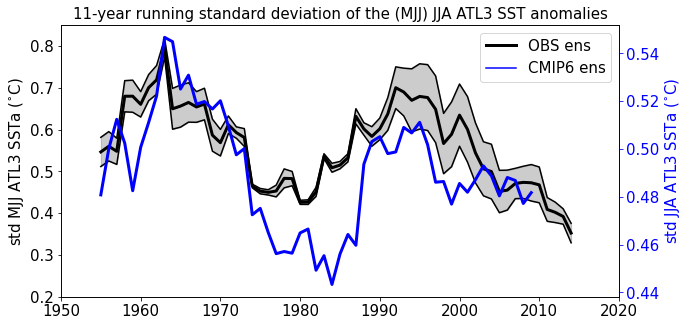

In [28]:
f,ax = plt.subplots(1,1,figsize=[10,5])
ftz=15
#ax.plot(date_center_era5,std_ssta_hadi_atl3_mjj_11yr_window,
#       color='orange',label='HadI-SST')
#ax.plot(date_center_era5,std_ssta_era5_atl3_mjj_11yr_window,
#        color='purple',label='ERA5')
ax.plot(date_center_era5,np.mean(ens_obs,0),
           color='black',linewidth=3,label='OBS ens')
ax.plot(date_center_era5,np.mean(ens_obs,0)+np.std(ens_obs,0),
           color='black')
ax.plot(date_center_era5,np.mean(ens_obs,0)-np.std(ens_obs,0),
           color='black')
ax.fill_between(date_center_era5,np.mean(ens_obs,0),np.mean(ens_obs,0)+np.std(ens_obs,0),color='black',alpha=0.2)
ax.fill_between(date_center_era5,np.mean(ens_obs,0),np.mean(ens_obs,0)-np.std(ens_obs,0),color='black',alpha=0.2)
ax.plot(0,0,
         color='blue',label='CMIP6 ens')
ax.legend(fontsize=ftz)
ax.set_title('11-year running standard deviation of the (MJJ) JJA ATL3 SST anomalies',fontsize=ftz)
ax.tick_params(labelsize=ftz)
ax.set_ylabel('std MJJ ATL3 SSTa ($^{\circ}$C)',fontsize=ftz,color='black')
ax.set_xlim(1950,2020)
ax.set_ylim(0.2,0.85)
ax1 = ax.twinx()
ax1.plot(date_center_cmip6,np.mean(std_ssta_cmip6_atl3_jja_11yr_window,0),color='blue',linewidth=3)
#ax1.plot(date_center_cmip6,np.mean(std_ssta_cmip6_atl3_jja_11yr_window,0)+
#         np.std(std_ssta_cmip6_atl3_jja_11yr_window,0),color='black',linewidth=1)
#ax1.plot(date_center_cmip6,np.mean(std_ssta_cmip6_atl3_jja_11yr_window,0)-
#         np.std(std_ssta_cmip6_atl3_jja_11yr_window,0),color='black',linewidth=1)
ax1.tick_params(labelsize=ftz,colors='blue')
ax1.set_ylabel('std JJA ATL3 SSTa ($^{\circ}$C)',fontsize=ftz,color='blue')

plt.savefig(path_fig + 'figure_R0.png',
            dpi = 300,
            bbox_inches='tight')